In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('/content/cafethai_prices.csv', parse_dates=['date'], date_format='%d/%m/%Y')
display(df.head())


,date,time,cash_type,coffee_name,money
0,2023-03-01,08:04:19,card,Latte,75
1,2023-03-01,08:08:54,cash,Americano with Milk,70
2,2023-03-01,08:09:03,card,Cappuccino,75
3,2023-03-01,08:10:26,cash,Cappuccino,75
4,2023-03-01,08:15:37,cash,Cappuccino,75


In [ ]:
df.set_index('date', inplace=True)

df.head()

,time,cash_type,coffee_name,money
date,,,,
2023-03-01,08:04:19,card,Latte,75
2023-03-01,08:08:54,cash,Americano with Milk,70
2023-03-01,08:09:03,card,Cappuccino,75
2023-03-01,08:10:26,cash,Cappuccino,75
2023-03-01,08:15:37,cash,Cappuccino,75


In [ ]:
daily_item = (df.groupby([df.index, 'coffee_name']).size().reset_index(name='cups_sold'))
daily_item.head()

,date,coffee_name,cups_sold
0,2023-03-01,Americano,19
1,2023-03-01,Americano with Milk,27
2,2023-03-01,Cappuccino,24
3,2023-03-01,Cocoa,7
4,2023-03-01,Cortado,14


In [ ]:
# ตั้งค่าระยะเวลาพยากรณ์ (60 วัน = ~2 เดือน)
prediction_length = 60

forecasts = {}
total_expected_sales = 0  # เก็บยอดรวมทุกรายการ

for product in daily_item["coffee_name"].unique():
    product_data = daily_item[daily_item["coffee_name"] == product].copy()
    product_data = product_data.sort_values("date")

    # ค่าเฉลี่ยต่อวัน
    avg_daily_sales = product_data["cups_sold"].mean()

    # คาดการณ์ยอดขายรวม 60 วัน
    expected_2months_sales = avg_daily_sales * prediction_length
    total_expected_sales += expected_2months_sales

    print(f"\n{product}: ค่าเฉลี่ยต่อวัน = {avg_daily_sales:.2f} แก้ว ,"
          f" คาดว่า 60 วัน ≈ {expected_2months_sales:.0f} แก้ว")

print(f"\nจำนวนแก้วที่ขายได้ในแต่ละวันโดยแยกเป็นแต่ละเมนู เป็นเวลา 2 เดือน  {total_expected_sales:.0f} แก้ว")


Americano: ค่าเฉลี่ยต่อวัน = 13.70 แก้ว , คาดว่า 60 วัน ≈ 822 แก้ว

Americano with Milk: ค่าเฉลี่ยต่อวัน = 19.16 แก้ว , คาดว่า 60 วัน ≈ 1149 แก้ว

Cappuccino: ค่าเฉลี่ยต่อวัน = 12.38 แก้ว , คาดว่า 60 วัน ≈ 743 แก้ว

Cocoa: ค่าเฉลี่ยต่อวัน = 5.85 แก้ว , คาดว่า 60 วัน ≈ 351 แก้ว

Cortado: ค่าเฉลี่ยต่อวัน = 7.02 แก้ว , คาดว่า 60 วัน ≈ 421 แก้ว

Espresso: ค่าเฉลี่ยต่อวัน = 3.70 แก้ว , คาดว่า 60 วัน ≈ 222 แก้ว

Hot Chocolate: ค่าเฉลี่ยต่อวัน = 6.98 แก้ว , คาดว่า 60 วัน ≈ 419 แก้ว

Latte: ค่าเฉลี่ยต่อวัน = 18.70 แก้ว , คาดว่า 60 วัน ≈ 1122 แก้ว

จำนวนแก้วที่ขายได้ในแต่ละวันโดยแยกเป็นแต่ละเมนู เป็นเวลา 2 เดือน  5249 แก้ว


In [ ]:
def create_features(df_ts, target_col):
    ts = df_ts.set_index('date').asfreq('D').copy()
    ts[target_col] = ts[target_col].fillna(0)
    ts['dayofweek'] = ts.index.dayofweek
    ts['month']     = ts.index.month
    ts['lag_7']     = ts[target_col].shift(7)
    ts['rolling_mean_7'] = ts[target_col].shift(1).rolling(7).mean()
    ts = ts.dropna()
    FEATURES = ['dayofweek','month','lag_7','rolling_mean_7']
    return ts, FEATURES

daily_total_sales = daily_item.groupby('date')['cups_sold'].sum().reset_index(name='total_cups')

daily_total_sales_features, FEATURES = create_features(daily_total_sales, 'total_cups')

display(daily_total_sales_features.head())

,total_cups,dayofweek,month,lag_7,rolling_mean_7
date,,,,,
2023-03-08,106,2,3,125.0,108.857143
2023-03-09,105,3,3,125.0,106.142857
2023-03-10,103,4,3,127.0,103.285714
2023-03-11,81,5,3,64.0,99.857143
2023-03-12,53,6,3,66.0,102.285714


In [42]:
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import pandas as pd

def fit_and_forecast_per_item_lite(df_all, item_name, model_type='xgb', forecast_days=60, split_ratio=0.85):
    sub = df_all[df_all['coffee_name']==item_name][['date','cups_sold']].copy()
    if sub.empty: return None
    ts, FEATURES = create_features(sub, 'cups_sold')
    n = len(ts)
    if n < 30: return None

    split_idx = int(n*split_ratio)
    Xtr, ytr = ts[FEATURES].iloc[:split_idx], ts['cups_sold'].iloc[:split_idx]
    Xte, yte = ts[FEATURES].iloc[split_idx:], ts['cups_sold'].iloc[split_idx:]

    if model_type=='rf':
        model = RandomForestRegressor(n_estimators=300, random_state=42)
        model_name = 'RandomForest'
    else:
        model = xgb.XGBRegressor(n_estimators=400, learning_rate=0.05, max_depth=6,
                                 subsample=0.9, colsample_bytree=0.9, random_state=42)
        model_name = 'XGBoost'
    model.fit(Xtr, ytr)
    mae = mean_absolute_error(yte, model.predict(Xte))

    last = ts.index.max()
    fut_idx = pd.date_range(last + pd.Timedelta(days=1), periods=forecast_days, freq='D')
    fut_feat = pd.DataFrame(index=fut_idx)

    fut_feat['dayofweek'] = fut_feat.index.dayofweek
    fut_feat['month']     = fut_feat.index.month

    tail = ts[['cups_sold']].tail(14).copy()
    tail['dayofweek'] = tail.index.dayofweek
    tail['month']     = tail.index.month
    tmp = pd.concat([tail, fut_feat], axis=0)
    tmp['lag_7'] = tmp['cups_sold'].shift(7)
    tmp['rolling_mean_7'] = tmp['cups_sold'].shift(1).rolling(7).mean()
    futX = tmp.loc[fut_idx, ['dayofweek','month','lag_7','rolling_mean_7']].fillna(0)

    fut_pred = model.predict(futX)
    forecast_df = pd.DataFrame({'forecast': fut_pred}, index=fut_idx)
    history_df = ts[['cups_sold']].rename(columns={'cups_sold':'actual'})

    return {'item': item_name, 'model_name': model_name, 'mae': mae,
            'history': history_df, 'test_range': Xte.index,
            'forecast': forecast_df, 'model': model}

In [43]:
ITEM_COL = 'coffee_name'
FORECAST_DAYS = 60

items = daily_item[ITEM_COL].unique().tolist()
results_per_item = {}

for it in items:
    r_x = fit_and_forecast_per_item_lite(daily_item, it, 'xgb', FORECAST_DAYS)
    r_r = fit_and_forecast_per_item_lite(daily_item, it, 'rf',  FORECAST_DAYS)
    if r_x is None and r_r is None:
        continue
    pick = r_x if (r_r is None or (r_x and r_x['mae']<=r_r['mae'])) else r_r
    results_per_item[it] = pick

import pandas as pd
mae_table = pd.DataFrame([
    {'item': it, 'model': r['model_name'], 'MAE': r['mae']}
    for it, r in results_per_item.items()
]).sort_values('MAE')
display(mae_table.head(10))

,item,model,MAE
5,Espresso,RandomForest,1.673593
3,Cocoa,RandomForest,2.486311
6,Hot Chocolate,RandomForest,2.731525
4,Cortado,RandomForest,2.806818
0,Americano,RandomForest,4.066479
2,Cappuccino,RandomForest,4.239696
7,Latte,RandomForest,4.737274
1,Americano with Milk,XGBoost,4.993213


In [44]:

items = daily_item['coffee_name'].unique().tolist()
results_per_item = {}

if 'FORECAST_DAYS' not in locals():
    FORECAST_DAYS = 60

for it in items:

    r_xgb = fit_and_forecast_per_item_lite(daily_item, it, model_type='xgb', forecast_days=FORECAST_DAYS)
    r_rf  = fit_and_forecast_per_item_lite(daily_item, it, model_type='rf',  forecast_days=FORECAST_DAYS)

    if r_xgb is None and r_rf is None:
        continue

    if r_rf is None or (r_xgb and r_xgb['mae'] <= r_rf['mae']):
        results_per_item[it] = r_xgb
    else:
        results_per_item[it] = r_rf

print(f"จำนวนเมนูที่พยากรณ์ได้: {len(results_per_item)}")

จำนวนเมนูที่พยากรณ์ได้: 8


In [45]:
if results_per_item:
    mae_table = pd.DataFrame([
        {'item': it, 'model': res['model_name'], 'MAE': res['mae']}
        for it, res in results_per_item.items()
    ]).sort_values('MAE')
    display(mae_table.head(10))
else:
    print("No items were forecasted successfully.")

,item,model,MAE
5,Espresso,RandomForest,1.673593
3,Cocoa,RandomForest,2.486311
6,Hot Chocolate,RandomForest,2.731525
4,Cortado,RandomForest,2.806818
0,Americano,RandomForest,4.066479
2,Cappuccino,RandomForest,4.239696
7,Latte,RandomForest,4.737274
1,Americano with Milk,XGBoost,4.993213


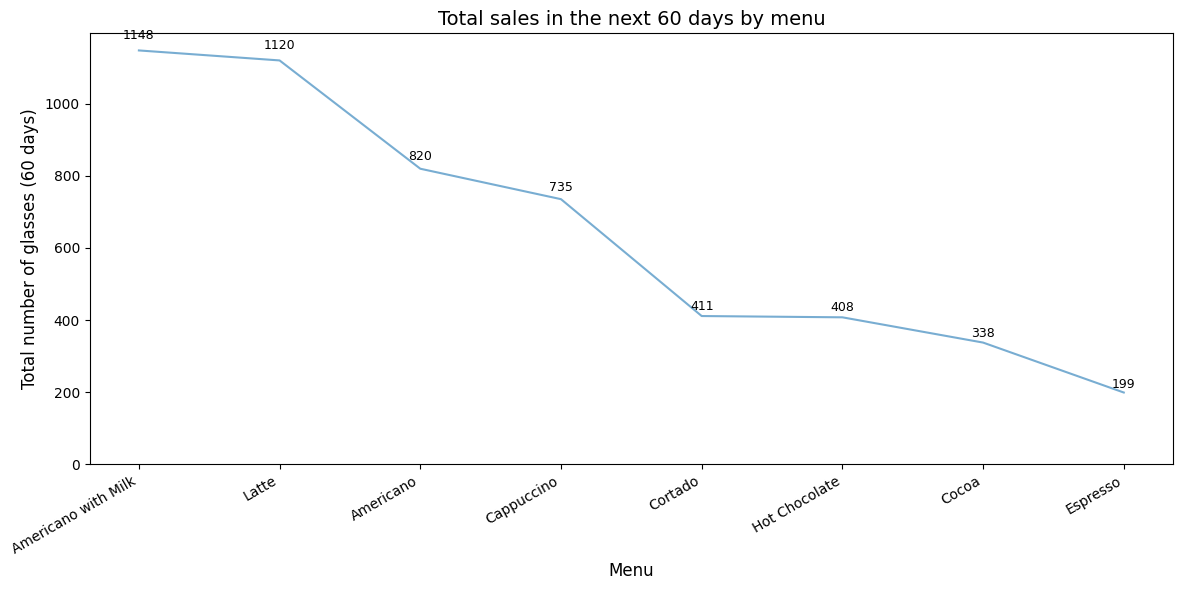

In [46]:
continuous = []
for it, g in daily_item.groupby('coffee_name'):
    # Ensure 'date' is the index before using asfreq
    s = g.set_index('date')['cups_sold'].asfreq('D', fill_value=0) # Use 'cups_sold' as the value column
    continuous.append(s.rename(it))
continuous = pd.concat(continuous, axis=1)
avg_daily = continuous.mean(axis=0)

forecast_60d = (avg_daily * 60).sort_values(ascending=False)

plt.figure(figsize=(12,6))
plt.plot(forecast_60d.index, forecast_60d.values, alpha=0.6)

for i, v in enumerate(forecast_60d.values):
    offset = max(v * 0.02, 1)
    plt.text(i, v + offset, f'{v:.0f}', ha='center', va='bottom', fontsize=9)

plt.title('Total sales in the next 60 days by menu', fontsize=14)
plt.xlabel('Menu', fontsize=12)
plt.ylabel('Total number of glasses (60 days)', fontsize=12)
plt.xticks(rotation=30, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.ylim(bottom=0)
plt.margins(x=0.05)
plt.tight_layout()
plt.show()